In [2]:
import cv2
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random
import pickle
import math
import warnings
import math
warnings.filterwarnings('ignore')

### Create dataset

In [3]:
df = pd.read_csv('/data1/Itzel/id_and_label_10000.csv')

In [4]:
root_dir = '/data1/Heerlen_HR_2018/full/'

In [5]:
def path_list(df, root_dir):
    img_dirs_list = []
    for image_file in df.iloc[:,0]:
        path = root_dir + image_file
        img_dirs_list.append(path)
    return img_dirs_list

In [6]:
def get_dataset_name(file_name_with_dir):
    filename_without_dir = file_name_with_dir.split('/')[-1]
    return filename_without_dir

In [7]:
def concatenate_data(data_paths, df):
    data = []
    labels = []
    dictionary = dict(zip(df['unique_id'], df['label']))
    for path in data_paths:     
        # data
        img_matrix = cv2.imread(path)
        img_resized = cv2.resize(img_matrix, (187,187))
        data.append(img_resized)
        # labels
        img_file = get_dataset_name(path)
        lab = dictionary[img_file]
        labels.append(lab)
        
        if len(data) % 1000 == 0:
            print('{} of {} samples processed'.format(len(data), len(df)))
    return np.array(data), np.array(labels)

In [8]:
data_paths = path_list(df, root_dir)

In [9]:
len(data_paths)

10000

In [10]:
data, labels = concatenate_data(data_paths, df)

1000 of 10000 samples processed
2000 of 10000 samples processed
3000 of 10000 samples processed
4000 of 10000 samples processed
5000 of 10000 samples processed
6000 of 10000 samples processed
7000 of 10000 samples processed
8000 of 10000 samples processed
9000 of 10000 samples processed
10000 of 10000 samples processed


In [11]:
count = 0
for label in labels:
    if label == int(1):
        count = count + 1
count

4672

In [12]:
# print(data.shape)
# print(labels.shape)

#### Create the VGG16 object

In [36]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model, load_model

In [14]:
# model_path = '/data1/model.hdf5'
# model = load_model(model_path)

In [15]:
# layer_names = [layer.name for layer in model.layers]

In [16]:
# int_layer_model = Model(inputs=model.input,
#                        outputs=model.get_layer('flatten_1').output)

#### Feature vectors for random sample

In [17]:
# def create_feature_list(path):
#     vgg16_feature_list = []
#     for im in path:
#         img = image.load_img(im, target_size=(187, 187))
#         img_data = image.img_to_array(img)
#         img_data = np.expand_dims(img_data, axis=0)
#         img_data = preprocess_input(img_data) # from RGB to BGR
#         vgg16_feature = int_layer_model.predict(img_data)
#         vgg16_feature_np = np.array(vgg16_feature)
#         vgg16_feature_list.append(vgg16_feature_np.flatten())
#         if len(vgg16_feature_list) % 100 == 0:
#             print(len(vgg16_feature_list))
#     return np.array(vgg16_feature_list)

In [18]:
# feature_list = create_feature_list(data_paths)

In [19]:
# feature_list.shape

In [20]:
# with open('/data1/Itzel/Clustering/feature_vectors_10000.pkl', 'wb') as f:
#     pickle.dump(feature_list, f)

In [21]:
with open('/data1/Itzel/Clustering/feature_vectors_10000.pkl', 'rb') as f:
    feature_list = pickle.load(f)

In [22]:
len(feature_list)

10000

## Create the functions

In [23]:
def group_indices_per_group(group_nr, labels):
    group_indices_list = []
    for index, group in enumerate(labels):
        if labels[index] == group_nr:
            group_indices_list.append(index)
    return group_indices_list

In [24]:
def group_indices(nr_groups, labels):
    list_of_list_indices = []
    for i in range(nr_groups):
        group_indices = group_indices_per_group(i, labels)
        list_of_list_indices.append(group_indices)
    return list_of_list_indices

In [25]:
def index_group_indices(nr_groups, labels):
    all_group_indices = group_indices(nr_groups, labels)
    all_group_indices_with_index = []
    for group_index, elements in enumerate(all_group_indices):
        all_group_indices_with_index.append((group_index, elements))
    return dict(all_group_indices_with_index)

In [26]:
def group_data(group_indices, path):
    images = []
    for i in group_indices:
        im = image.load_img(path[i])
        arr_img = image.img_to_array(im)
        images.append(arr_img)
    return np.array(images)

In [27]:
def print_nrsamples_per_cluster(dictionary):
    one_sample_keys = []
    zero_sample_keys = []
    for key, value in dictionary.items():
        if len(value) > 1:
            print('Cluster: {} || Nr of samples: {}'.format(key, len(value)))
        if len(value) == 1:
            one_sample_keys.append(key)
        if len(value) == 0:
            zero_sample_keys.append(key)
    print(' ')
    print('Clusters with only 1 sample:', one_sample_keys)
    print('Clusters with 0 samples:', zero_sample_keys)

In [28]:
def create_labels_per_group(group_nr, group_indices_dict, sample_labels):

    sample_indices_group = group_indices_dict[group_nr]
    labels_group = []
    for index in sample_indices_group:
        labels_group.append(int(sample_labels[index]))
    return labels_group

In [29]:
def compute_positives(labels_of_cluster):
    count = 0
    for label in labels_of_cluster:
        if label == 1:
            count += 1
    total = len(labels_of_cluster)
    proportion = count/total*100
    print('{} of {} group samples from group are positive, percentage: {}'.format(count, total,proportion)) 

## Run it

In [30]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import pairwise_distances
from sklearn import metrics

In [31]:
nr_clusters = 5
aff = 'cosine'
link = 'complete'

In [32]:
# km = KMeans(n_clusters=nr_clusters,
#            random_state=random_state).fit(feature_list)
# km_labels = km.labels_
# index_group_dict = index_group_indices(nr_clusters, km_labels) # key = cluster_nr, value = list of data indices
# print(metrics.silhouette_score(feature_list, km_labels, metric='euclidean'))
# print(metrics.calinski_harabasz_score(feature_list, km_labels))

In [33]:
agg = AgglomerativeClustering(n_clusters=nr_clusters,
                              distance_threshold=None,
                              compute_full_tree=True,
                              affinity=aff,
                              linkage=link).fit(feature_list)
agg_labels = agg.labels_
index_group_dict = index_group_indices(nr_clusters, agg_labels) # key = cluster_nr, value = list of data indices
print(metrics.silhouette_score(feature_list, agg_labels, metric='euclidean'))
print(metrics.calinski_harabasz_score(feature_list, agg_labels))

0.32557115
942.7326052219909


In [34]:
print_nrsamples_per_cluster(index_group_dict)

Cluster: 0 || Nr of samples: 1158
Cluster: 1 || Nr of samples: 817
Cluster: 2 || Nr of samples: 1140
Cluster: 3 || Nr of samples: 883
Cluster: 4 || Nr of samples: 6002
 
Clusters with only 1 sample: []
Clusters with 0 samples: []


In [37]:
# group data of clusters 2, 11 and 25
group0_data = group_data(index_group_dict[0], data_paths)
group1_data = group_data(index_group_dict[1], data_paths)
group2_data = group_data(index_group_dict[2], data_paths)
group3_data = group_data(index_group_dict[3], data_paths)
group4_data = group_data(index_group_dict[4], data_paths)

In [38]:
classes_0 = create_labels_per_group(0, index_group_dict, labels)
classes_1 = create_labels_per_group(1, index_group_dict, labels)
classes_2 = create_labels_per_group(2, index_group_dict, labels)
classes_3 = create_labels_per_group(3, index_group_dict, labels)
classes_4 = create_labels_per_group(4, index_group_dict, labels)

In [39]:
compute_positives(classes_0)
compute_positives(classes_1)
compute_positives(classes_2)
compute_positives(classes_3)
compute_positives(classes_4)

1102 of 1158 group samples from group are positive, percentage: 95.16407599309153
787 of 817 group samples from group are positive, percentage: 96.32802937576498
1064 of 1140 group samples from group are positive, percentage: 93.33333333333333
820 of 883 group samples from group are positive, percentage: 92.8652321630804
899 of 6002 group samples from group are positive, percentage: 14.97834055314895


### Create a new csv file for the retrieved clusters

In [88]:
# def create_index_path_link(index_group_dict, cluster_nr):
#     cluster_paths = dict()
#     for data_index in index_group_dict[cluster_nr]:
#         cluster_sample_path = data_paths[data_index]
#         cluster_paths[data_index] = cluster_sample_path.split('/')[-1]
#     return cluster_paths    

In [143]:
# cluster0_paths = create_index_path_link(index_group_dict, 0)
# cluster1_paths = create_index_path_link(index_group_dict, 1)
# cluster2_paths = create_index_path_link(index_group_dict, 2)
# cluster3_paths = create_index_path_link(index_group_dict, 3)
# cluster4_paths = create_index_path_link(index_group_dict, 4)

In [144]:
# def add_cluster_to_value(cluster_paths, cluster_nr):
#     for key, value in cluster_paths.items():
#         cluster_paths[key] = [value, cluster_nr]
#     return cluster_paths

In [145]:
# cluster0_paths = add_cluster_to_value(cluster0_paths, 0)
# cluster1_paths = add_cluster_to_value(cluster1_paths, 1)
# cluster2_paths = add_cluster_to_value(cluster2_paths, 2)
# cluster3_paths = add_cluster_to_value(cluster3_paths, 3)
# cluster4_paths = add_cluster_to_value(cluster4_paths, 4)

In [147]:
# def merge_dicts():
#     cluster0_paths.update(cluster1_paths)
#     cluster0_paths.update(cluster2_paths)
#     cluster0_paths.update(cluster3_paths)
#     cluster0_paths.update(cluster4_paths)
#     sorted_items = sorted(cluster0_paths.items())
#     return dict(sorted_items)

In [149]:
# final_dict = merge_dicts()

In [160]:
# def func():
#     new_dict = dict()
#     for key, value in final_dict.items():
#         new_dict[value[0]] = value[1]
#     return new_dict

In [161]:
# final_dict = func()

In [163]:
# import csv
# new_file = open('/data1/Itzel/id_and_label_clusters.csv', 'w')
# writer = csv.writer(new_file)
# writer.writerow(['unique_id', 'label'])
# for unique_id, label in final_dict.items():
#     writer.writerow([unique_id, label])
# new_file.close()

### Visualize the clusters

In [ ]:
def visualize_4neighbors(group_data):
    fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(5, 5))
    data = random.sample(list(group_data), 4)
    
    ax1[0].set_axis_off()
    ax1[1].set_axis_off()
    ax2[0].set_axis_off()
    ax2[1].set_axis_off()
    
    ax1[0].imshow(data[0]/255)
    ax1[1].imshow(data[1]/255)
    ax2[0].imshow(data[2]/255)
    ax2[1].imshow(data[3]/255)

In [ ]:
visualize_4neighbors(group0_data)

In [ ]:
visualize_4neighbors(group1_data)

In [ ]:
visualize_4neighbors(group2_data)

In [ ]:
visualize_4neighbors(group3_data)

In [ ]:
visualize_4neighbors(group4_data)

In [58]:
def visualize_5neighbors(group_data, start_index):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 2))
    data = group_data[start_index:start_index+5]
    for index, ax in enumerate([ax1,ax2,ax3,ax4,ax5]):
        ax.set_axis_off()
        ax.imshow(data[index]/255)

In [59]:
def visualize_multiple_samples(group_data,start_index, nr_rows):
    for i in range(nr_rows):
        visualize_5neighbors(group_data, start_index)
        start_index = start_index + 5

In [144]:
# visualize_5neighbors(group0_data, 0)

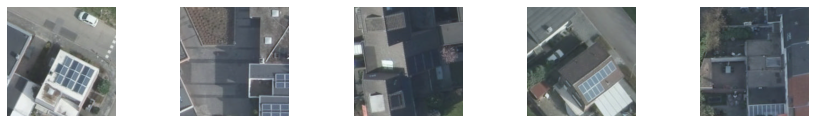

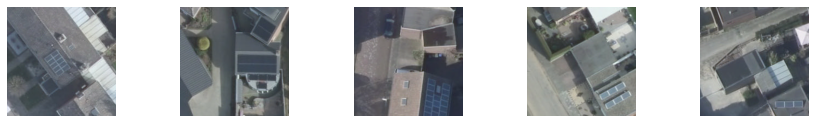

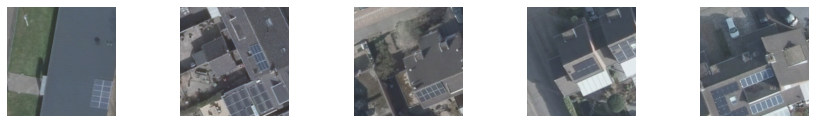

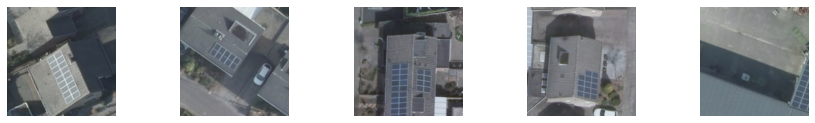

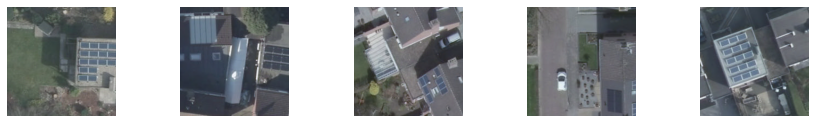

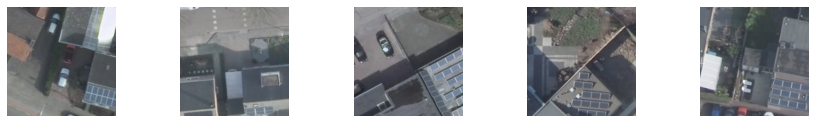

In [64]:
visualize_multiple_samples(group0_data,0, 6)

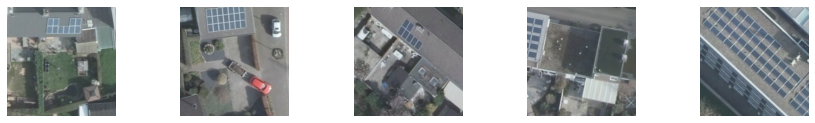

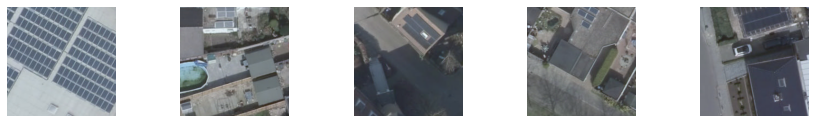

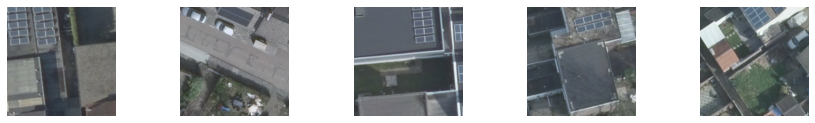

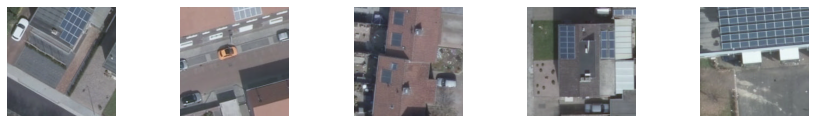

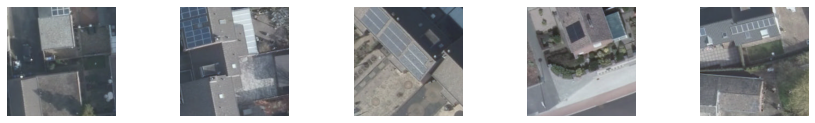

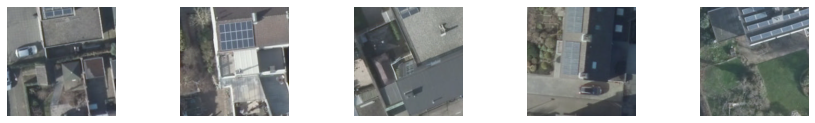

In [65]:
visualize_multiple_samples(group2_data,0, 6)

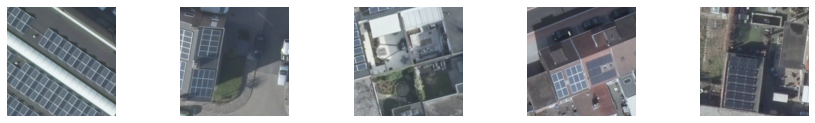

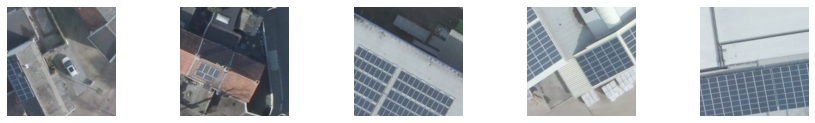

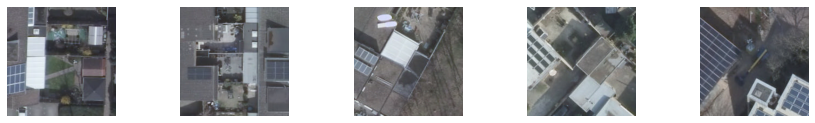

In [62]:
visualize_multiple_samples(group3_data,0, 3)

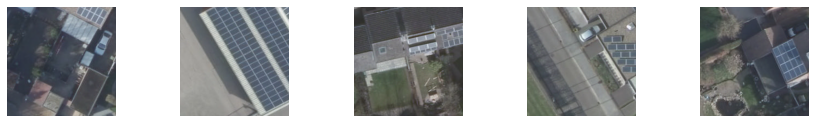

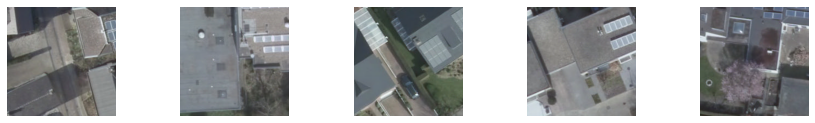

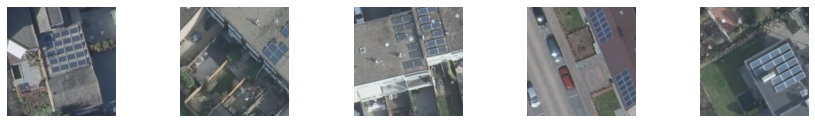

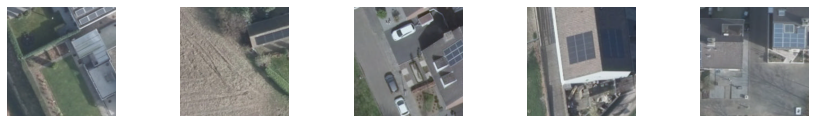

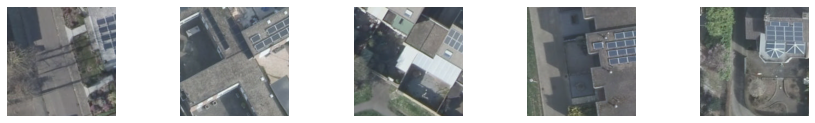

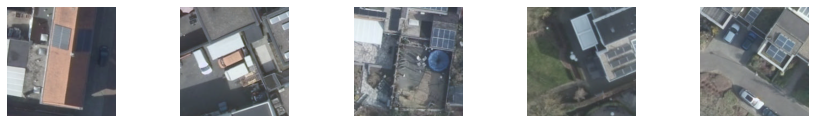

In [66]:
visualize_multiple_samples(group4_data,0, 6)